In [1]:
import pandas as pd

In [2]:
tmp_df = pd.read_csv('/home/spark/Documents/Marco/train_yn.csv')

In [3]:
df_train = spark.createDataFrame(tmp_df)

In [4]:
df_train.show(10)

+--------------------+--------------------+--------+-----------+----------+
|            passages|               query|query_id| query_type|answers_yn|
+--------------------+--------------------+--------+-----------+----------+
|[Row(is_selected=...|was ronald reagan...|   19700|description|       Yes|
|[Row(is_selected=...|do game shows pay...|   19749|description|       Yes|
|[Row(is_selected=...|does peanut butte...|   19761|description|        No|
|[Row(is_selected=...|can you take left...|   19762|description|        No|
|[Row(is_selected=...|is armed assault ...|   19774|description|       Yes|
|[Row(is_selected=...|is silverbeet the...|   19784|description|       Yes|
|[Row(is_selected=...|are springtails h...|   19813|description|        No|
|[Row(is_selected=...|are angora goats ...|   19829|description|       Yes|
|[Row(is_selected=...|are angora goats ...|   19829|description|        No|
|[Row(is_selected=...|does visa signatu...|   19830|description|       yes|
+-----------

In [5]:
df_train_sub = df_train.drop('passages').drop('query_id')

In [6]:
del(tmp_df)
del(df_train)

In [7]:
df_train_sub.show(10)

+--------------------+-----------+----------+
|               query| query_type|answers_yn|
+--------------------+-----------+----------+
|was ronald reagan...|description|       Yes|
|do game shows pay...|description|       Yes|
|does peanut butte...|description|        No|
|can you take left...|description|        No|
|is armed assault ...|description|       Yes|
|is silverbeet the...|description|       Yes|
|are springtails h...|description|        No|
|are angora goats ...|description|       Yes|
|are angora goats ...|description|        No|
|does visa signatu...|description|       yes|
+--------------------+-----------+----------+
only showing top 10 rows



In [8]:
# convert yes no to 1 o

df_train_sub=df_train_sub.na.replace(['yes', 'no'], ['Yes', 'No'], 'answers_yn')
df_train_sub=df_train_sub.na.replace(['Yes', 'No'], ['1', '0'], 'answers_yn')

df_train_sub.show()

+--------------------+-----------+----------+
|               query| query_type|answers_yn|
+--------------------+-----------+----------+
|was ronald reagan...|description|         1|
|do game shows pay...|description|         1|
|does peanut butte...|description|         0|
|can you take left...|description|         0|
|is armed assault ...|description|         1|
|is silverbeet the...|description|         1|
|are springtails h...|description|         0|
|are angora goats ...|description|         1|
|are angora goats ...|description|         0|
|does visa signatu...|description|         1|
|can we skip amica...|description|         1|
|can i update the ...|description|         1|
|is the new tesla ...|description|         1|
|does delirium cau...|description|         1|
|does claritin hel...|description|         1|
|is mount everest ...|description|         1|
|do hopi ear candl...|description|         1|
|is facility explo...|description|         1|
|if a potato gets ...|description|

In [9]:
import nltk

In [10]:
sentence = df_train_sub.select('query').limit(1).collect()

In [11]:
print sentence[0][0]
token = nltk.word_tokenize(str(sentence[0][0]))
print token

was ronald reagan a democrat
['was', 'ronald', 'reagan', 'a', 'democrat']


In [12]:
nltk.FreqDist(token)

FreqDist({'a': 1, 'democrat': 1, 'reagan': 1, 'ronald': 1, 'was': 1})

In [13]:
df_train_sub.createOrReplaceTempView('tmp')
# df_1 = spark.sql('select * from tmp limit 1')
# df_train_sub.limit(2).show()

In [14]:
def term_fre(doc):
    token = nltk.word_tokenize(str(doc[0]))
    tf = nltk.FreqDist(token)
    return dict(tf)

In [15]:
lst_tf = []
for i in df_train_sub.select('query').collect():
    lst_tf.append(term_fre(i))

In [16]:
import h2o

In [17]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_111"; Java(TM) SE Runtime Environment (build 1.8.0_111-b14); Java HotSpot(TM) 64-Bit Server VM (build 25.111-b14, mixed mode)
  Starting server from /home/spark/anaconda2/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpoVYsnO
  JVM stdout: /tmp/tmpoVYsnO/h2o_spark_started_from_python.out
  JVM stderr: /tmp/tmpoVYsnO/h2o_spark_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,05 secs
H2O cluster version:,3.10.0.10
H2O cluster version age:,1 month and 28 days
H2O cluster name:,H2O_from_python_spark_ijb36m
H2O cluster total nodes:,1
H2O cluster free memory:,875 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [18]:
hdf_tf=h2o.H2OFrame(lst_tf)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [19]:
hdf_target=h2o.H2OFrame(df_train_sub.select('answers_yn').collect())

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [20]:
hdf = h2o.H2OFrame.cbind(hdf_tf,h2o.H2OFrame.asfactor(hdf_target))

In [21]:
hdf

C1,C10
"{'ronald': 1, 'was': 1, 'reagan': 1, 'a': 1, 'democrat': 1}",1
"{'do': 1, 'game': 1, 'contestants': 1, 'pay': 1, 'their': 1, 'shows': 1}",1
"{'butter': 1, 'peanut': 1, 'contain': 1, 'does': 1, 'cholesterol': 1}",0
"{'a': 1, 'on': 1, 'lane': 1, 'right': 1, 'to': 1, 'carriageway': 1, 'hand': 1, 'turn': 1, 'can': 1, 'dual': 1, 'you': 1, 'left': 1, 'roundabout': 1, 'take': 1}",0
"{'a': 1, 'felony': 1, 'is': 1, 'armed': 1, 'assault': 1}",1
"{'the': 1, 'as': 1, 'is': 1, 'silverbeet': 1, 'same': 1, 'chard': 1}",1
"{'harmful': 1, 'springtails': 1, 'are': 1}",0
"{'good': 1, 'meat': 1, 'for': 1, 'angora': 1, 'goats': 1, 'are': 1}",1
"{'good': 1, 'meat': 1, 'for': 1, 'angora': 1, 'goats': 1, 'are': 1}",0
"{'does': 1, 'have': 1, 'signature': 1, 'assistance': 1, 'roadside': 1, 'visa': 1}",1


In [48]:
hdf_train, hdf_validate=hdf.split_frame(ratios=[0.75], seed =1)

In [49]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [50]:
nb =H2ONaiveBayesEstimator(seed =1)
nb.train(x = hdf.col_names[0], y = hdf.col_names[1], training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [51]:
nb.auc()

0.006909803758099552

In [52]:
gbm_model = H2OGradientBoostingEstimator(seed =1)
gbm_model.train(x = hdf.col_names[0], y = hdf.col_names[1], training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


AUC:  0.751706058627
accuracy:  [[0.639517716488152, 0.795816939324912]]


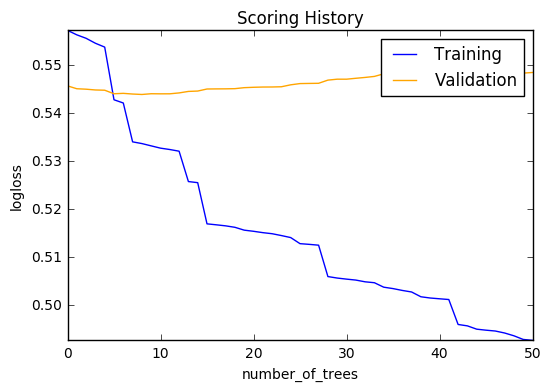

In [53]:
print "AUC: ", gbm_model.auc()
print "accuracy: ", gbm_model.accuracy()
gbm_model.plot()

In [54]:
gbm_model_2 = H2OGradientBoostingEstimator(ntrees=65,seed=1)
gbm_model_2.train(x = hdf.col_names[0], y = hdf.col_names[1], training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [67]:
print "AUC: ", gbm_model_2.auc()
print "accuracy: ", gbm_model_2.accuracy()
# gbm_model_2.plot()

H2OGradientBoostingEstimator.scoring_history(gbm_model_2)
# plot(h2o.pe)

AUC:  0.764013672553
accuracy:  [[0.6404097079885708, 0.7978877614412921]]


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
0,,2017-01-05 10:37:19,0.026 sec,0.0,0.430320,0.557216,0.500000,1.000000,0.245392,0.424193,0.545668,0.500000,1.000000,0.235112
1,,2017-01-05 10:37:19,0.066 sec,1.0,0.429911,0.556285,0.534468,1.208947,0.245392,0.423927,0.545073,0.523198,1.094551,0.235112
2,,2017-01-05 10:37:19,0.104 sec,2.0,0.429597,0.555566,0.554162,1.204720,0.245392,0.423883,0.544978,0.528809,1.099388,0.235112
3,,2017-01-05 10:37:19,0.146 sec,3.0,0.429143,0.554534,0.573588,1.244058,0.243943,0.423810,0.544818,0.529089,1.032142,0.235112
4,,2017-01-05 10:37:19,0.196 sec,4.0,0.428790,0.553734,0.577178,1.244058,0.243736,0.423780,0.544765,0.517508,1.055961,0.235112
5,,2017-01-05 10:37:19,0.268 sec,5.0,0.423587,0.542778,0.647962,1.325192,0.214951,0.423436,0.544031,0.531633,1.045904,0.233871
6,,2017-01-05 10:37:19,0.296 sec,6.0,0.423280,0.542106,0.649988,1.325192,0.214951,0.423475,0.544113,0.528778,1.111273,0.233871
7,,2017-01-05 10:37:19,0.324 sec,7.0,0.419160,0.534025,0.663210,1.325192,0.215158,0.423408,0.543972,0.530064,1.111273,0.233871
8,,2017-01-05 10:37:19,0.354 sec,8.0,0.419000,0.533667,0.666181,1.325192,0.215158,0.423361,0.543880,0.530221,1.111273,0.233871
9,,2017-01-05 10:37:19,0.386 sec,9.0,0.418779,0.533189,0.666333,1.325192,0.215780,0.423431,0.544034,0.529944,1.111273,0.233871


In [56]:
prediction = gbm_model.predict(hdf_validate[0])


gbm prediction progress: |████████████████████████████████████████████████| 100%


In [57]:
pdf_pred=prediction.as_data_frame()

In [58]:
print 'prediction unique values:', pdf_pred['predict'].unique()
print pdf_pred['predict'][0:10]
print hdf_validate.head(10)



prediction unique values: [1 0]
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: predict, dtype: int64


C1,C10
"{'butter': 1, 'peanut': 1, 'contain': 1, 'does': 1, 'cholesterol': 1}",0
"{'harmful': 1, 'springtails': 1, 'are': 1}",0
"{'does': 1, 'have': 1, 'signature': 1, 'assistance': 1, 'roadside': 1, 'visa': 1}",1
"{'tesla': 1, 'new': 1, 'is': 1, 'hybrid': 1, 'the': 1}",1
"{'a': 1, 'is': 1, 'plant': 1, 'moss': 1, 'spanish': 1}",1
"{'did': 1, 'on': 1, 'landed': 1, 'us': 1, 'moon': 1}",1
"{'farmhouse': 1, 'sinks': 1, 'laminate': 1, 'countertops': 1, 'with': 1, 'can': 1}",0
"{'on': 1, 'i': 1, 'saves': 1, 'xbox': 1, 'pc': 1, 'can': 1, 'put': 1, 'my': 1}",1
"{'for': 1, 'is': 1, 'there': 1, 'an': 1, 'limit': 1, 'learning': 1, 'speech': 1, 'age': 1}",0
"{'counsel': 1, 'of': 1, 'an': 1, 'not': 1, 'does': 1, 'are': 1, 'employee': 1, 'partner': 1, 'you': 1, 'or': 1, 'mean': 1}",0


# Playing with data
1. clean it
2. then word cloud

In [46]:
# import

In [34]:
lst_tf[1]

{'contestants': 1, 'do': 1, 'game': 1, 'pay': 1, 'shows': 1, 'their': 1}